# Meta-modeling tutorial <a id="header"></a>

### Tanmoy Sanyal, Sali lab (tsanyal@salilab.org)

Hi everyone, and welcome to this brief tutorial that provides a demonstration of Sali-lab's current efforts in meta-modeling. In a nut-shell "meta-modeling" is the process of establishing a platform that can harmonize different computational models of the cell.

The focus of this tutorial is on a (hopefully!) hands-on demonstration of how this platform works, so for computational simplicity, the <em>cell models</em> used here are toy models. It is instructive that you do <strong>not</strong> go looking for biological meaning in the results shown below, but rather follow the computational aspect of how we can design platforms that enable information flow between different seemingly disparate simulation models.

The tutorial is divided into three sections with increasing complexity. To keep the material general enough, certain implementation details have been intentionally coarse-grained out. Please feel free to interrupt and ask questions in between, or, for in-depth discussions, reach out to me later.

This document is divided into blocks called (sic) "cells". These cells sometimes contain live python code that you can execute. For this tutorial the code-cells have been pre-executed to produce output side-by-side with the text as you read along. But, you can always toggle a code cell to show the code and then re-run it by simply clicking the run button at the top left. Doing this will run the code cell and take you to the next cell below.
<br></br>
<br></br>
<div><img src="./tutorial_figs/run_button.png" width=500></div>

One last thing before you begin:
<br></br>
For ease of visualization, please click the button below to hide all other code cells and make the tutorial experience better. For those of you who are interested in the code, re-click the button to toggle code visibility on and off.

In [1]:
%%html
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle (show/hide) all code in this document"></form>

# Table of Contents <a id="toc"></a>
1. [Introduction](#intro)
    1. [Bayesian Modeling](#bayesian_modeling)
    2. [Meta-Modeling](#metamodeling)
    3. [Probabilistic Graphical Models](#pgm)
2. [Meta-Modeling 101: How do you couple different models (PGMs)?](#metamodeling_101)
    1. [The Treatment Model](#treatment_model)
    2. [The Growth Model](#growth_model)
    3. [The "Meta" Model](#meta_model)
    4. [Summary](#summary_2)
3. [Building a simple meta-model for beta-cell biology](#metamodeling_mm_spt)
    1. [Meal Model](#meal_model)
    2. [Spatio Temporal (SPT) Model](#spt_model)
    3. [The Meta Model (with a healthy dose of meta-modeling philosophy!)](#meta_model_mm_spt) 
    4. [Bayesian parameter inference from the meta-model](#meta_model_mm_spt_inference)
    5. [Summary and Outlook](#summary_3)

## 1. Introduction <a id="intro"></a>

### A. Bayesian Modeling <a id="bayesian_modeling"></a>
Let us first describe a general computational protocol that we use to develop models. This is going to be a very quick description of everything that Andrej explained yesterday. 

1. To model a biological system (e.g. the cell), we typically want to base our model ($M$) on some experimental data ($D$) as well as our prior information about the system ($\theta$). $M$ represents the degrees of freedom appropriate to the model: e.g. particle coordinates for a molecular simulation model, chemical concentrations for a pharmacokinetic (PK/PD) model, etc. Further they may be functions of time (dynamic) or not (static).


2. A useful way to choose a model that reflects the data and our prior knowledge is to pick it from a family of alternative models and define a quantitative score that distinguishes <em>good models</em> from <em>bad models</em>. Intuitively, good models are ones that make more or less sense in light of the (noisy and often ambiguous and incomplete) data $D$ and our prior knowledge $\theta$.


3. A practical way to score good or bad models is to assign a probability for each model given the data and our prior knowledge about the system $P(M \mid D, \theta)$. But how do we estimate this probability?


4. The standard practice is to ask what is the <strong>likelihood</strong> of the data given the model, i.e. $P(D \mid M)$, and what's the probability of the model degrees of freedom given our prior knowledge, i.e., $P(M \mid \theta)$, and then combine these estimates to answer the opposite question, i.e. what is the probability of the model given the data and prior knowledge, in other words, $P(M \mid D, \theta)$. For instance, the probability of a certain EM map to be generated from a certain model of the cell may be easier to compute than directly computing the probability of the cell model degrees of freedom given the EM map.


The last step can be achieved through [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) which states that:
<br></br>
<br></br>
<div> <img src="./tutorial_figs/bayes_theorem.png" width="500"> </div> 

### B. Meta-Modeling <a id="metamodeling"></a>
<a id="1.2"></a>
The ability to describe $P(M \mid D, \theta)$ given different independently determined sets of data $D$ is [Integrative Modeling](https://integrativemodeling.org/) as we know it today. But not all data may be available to all models, e.g. a PK/PD model deals with concentrations so presenting it with data on molecular co-ordinates would not make sense. That is where "meta-modeling" comes in! In meta-modeling, we go beyond coupling all available data to a single model, by <strong>coupling different models with their own "appropriate" data.</strong>. 

Interestingly, all input models need not have data available (i.e. the total amount of data available to the meta-model is incomplete with respect to the number of models). Meta-modeling ensures that the influence of data available to one model flows to another in a rigorous Bayesian fashion.

### C. Probabilistic Graphical Models (PGM) <a id="pgm"></a>
The theoretical framework that we'll eventually use to implement meta-modeling are <strong>probabilistic graphical models</strong> (PGM). These are graphical representations of complex joint probability distributions that enable efficient data storage and systematic protocols to understand the conditional inter-dependencies between different parts of the model (or for that matter different models, as we shall see in section 3).

What do PGMs look like? The most general PGM for a model $M$ with data $D$ and prior information $\theta$ can be drawn as:
<br></br>
<br></br>
<div><img src="tutorial_figs/bayes_theorem_pgm.png" width=250></div>

In a PGM like this, the nodes (circles) represent the variables (random variables), while edges capture the statistical dependencies between nodes by denoting <em>conditional probability distributions</em> (CPD)s, i.e. the probability of a node given the values of its parent nodes. Without going into too many details, the way to read a PGM like this one is to start from the root (i.e. nodes without parents) and keep multipying CPDs as you traverse edges in the direction the edge points to. As you can see, this is a very visually clear way to apply Bayes' theorem: as you multiply the edge CPDs $P(D \mid M)$, $P(M \mid \theta)$ and $P(\theta)$ (here you should interpret the node as the probability itself since it is a root), you get back the RHS of the equation in section [1.1](#bayesian_modeling)

In this representation, $P(M \mid \theta)$ is actually a probabilistic interpretation of the model equations (e.g. differential equations of species concentrations for PK/PD models or Newton's laws of motion for molecular dynamic simulators, etc.)

PGMs not only provide intuitively clear visualizations of complex probability distributions, it can be also shown (which we will not do here), that they lead to signigicant memory savings in storing the variables $M$, $D$ and $\theta$.

<strong>Probabilistic programming languages</strong> (PPL) are computational implementations of PGMs built in well known programming languages that enable fast Bayesian operations on such graphical models. In this tutorial, we'll use a well-known PPL called [PyMC3](https://docs.pymc.io), which is built on top of fast machine-learning libraries like [Theano](http://deeplearning.net/software/theano/) or [Tensorflow](https://www.tensorflow.org/).

## 2. Meta-Modeling 101: How do you couple different models (PGMs)? <a id="metamodeling_101"></a>

In [2]:
# import python libraries that will be required repeatedly

# general python stuff
import os
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt

# the PyMC3 package
import pymc3 as pm

sys.path.append("..")
from mm.core import jit # custom-wrapper for model compilation
from mm.utils import set_start # custom helper function to set starting point for timeseries models

# functions written to make my life easier while writing this tutorial
import tutorial_utils as tu

# number of samples to draw for plotting distributions
ns = 100

Now that you have seen what a model (in principle any simulation model) PGM looks like, lets see how to do meta-modeling by coupling two PGMs. Imagine you are studying the effect of a new drug on cancer cell growth. To make life simpler, lets focus on one particular tumor cell. You treated it with this magic drug and it did show some progress. Load the daily cell volume measurement (done over a period of 29 days) (kept in ```tutorial_datasets/tumor_vol.dat```)

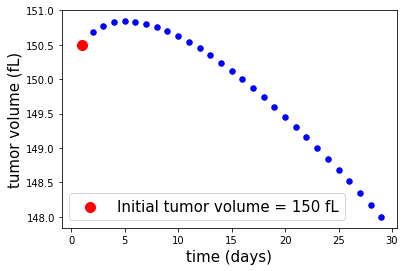

In [3]:
# extract data
data = np.loadtxt("./tutorial_datasets/tumor_vol.dat")
time_data = data[:,0]
tumor_volume_data = data[:,1]

# target values of variables used in this section
k1_target = 1.0
k2_target = 2.0
n_target = 0.75

# get starting cell volume 
initial_tumor_volume = tumor_volume_data[0]

# plot
plt.scatter(time_data, tumor_volume_data
, s=30, c="blue")
plt.scatter(time_data[0], initial_tumor_volume, s=100, c="red", label="Initial tumor volume = 150 fL")
plt.xlabel("time (days)", fontsize=15)
plt.ylabel("tumor volume (fL)", fontsize=15)
plt.legend(prop={"size": 15})
plt.show();

These are the data points, or as we referred to them earlier in mathematical language $D$. 

### A. The Treatment Model <a id="treatment_model"></a>

As the simplest possible model of the treatment, you assume that the tumor volume reduces linearly everyday according to $$V(t) = V_0 - k_1t$$ where $V_0$ is the starting volume of the tumor (~150 fL) and $k_1$ is the steady reduction rate. $k_1$ thus is a metric of the efficiency of this treatment. To relate back to the notation introduced in section [1.A](#bayesian_modeling),  the equation above represents a <em>family of models></em> such that $k_1$ represents the single degree of freedom of this model $M$. We want to choose the value of $k_1$ that <em>maximizes</em> the posterior probability of the model given data $P(M \mid D)$, i.e. $P(k_1 \mid D)$.

Based on your prior experiences with tumor cell models of this type (and also because you are a seasoned researcher :)), you have strong reason to believe that $k_1$ can be approximated as a Gaussian or Normal distribution with mean 0.8 fL/day and std. deviation 1.0 fL/day.

Lets build a PGM for this model and present it with the tumor volume data as evidence.

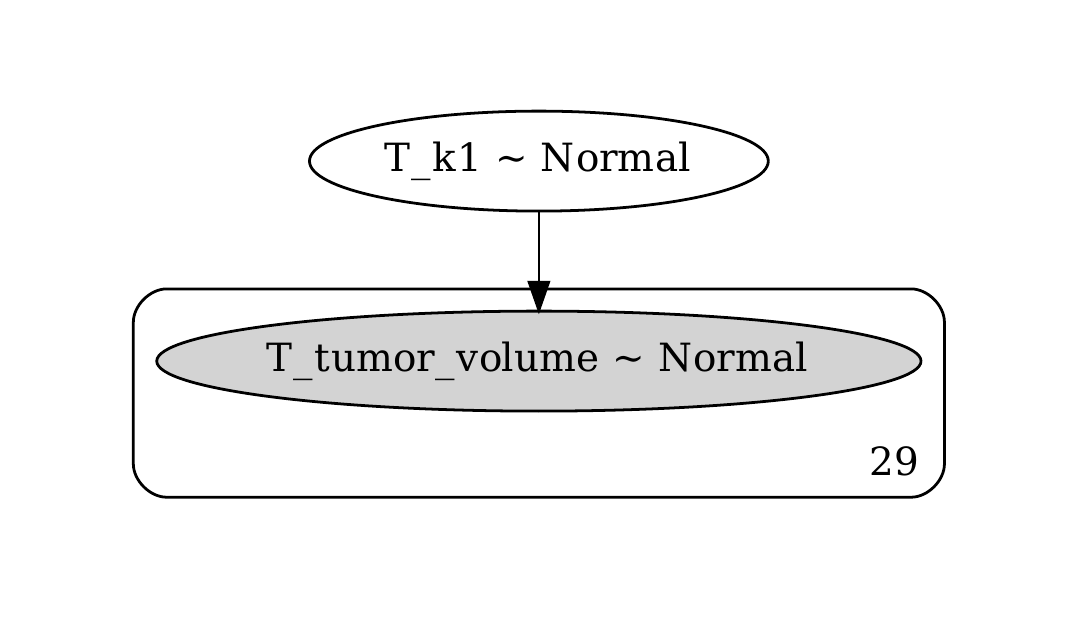

In [4]:
@jit
def TreatmentModel(name="T", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    k1 = pm.Normal("k1", mu=0.8, sigma=1.0)
    V = pm.Normal("tumor_volume", mu=V0-k1*t, sigma=1.0, shape=len(t))
    
m1 = TreatmentModel(name="T",
                    inputs={"t": time_data, "V0": initial_tumor_volume},
                    evidence={"T_tumor_volume": tumor_volume_data},
                    start={})
tu.visualize_model(m1)

What does the above graphical model represent?

1. The node ```T_k1``` is the reduction rate $k_1$ according to our treatment model, as explained above. The node ```T_tumor_volume``` is the volume of the tumor over time $V(t)$. The arrow represents that the tumor volume over time depends on the value of $k_1$. Thus $k_1$ is a free parameter of our model, and we would like to choose a value for $k_1$ that best explaiins our data.


2. The notation ```T_k1 ~ Normal``` means that the variable $k_1$ is distributed according to a Normal distribution (remember, that our prior knowledge says that $k_1$ belongs to a Normal distribution with mean 0.8 and std. dev 1.0, i.e. $k_1 \sim \mathcal{N}(0.8, 1.0)$. The parameters 0.8 and 1.0 that parameterize the prior distribution on $k_1$ are actually the parameter $\theta$ introduced in section [1.A](#bayesian_modeling). In this case they are not assigned a separate variable, because they are constants.

Also, let's quickly define some terms that will be necessary later. I won't go into too many details, but you are encouraged to reach out if you have questions. You might want to look at the code using the toggle button above to see where the terms below come from. 

1. <strong>MBF</strong>: The PGM is defined using a python function ```TreatmentModel()```. This function is called the "model-builder-function" or MBF. It can have any name, I arbitrarily chose the name "T". (I won't get into what the notation ```@jit``` means, but it should always come before defining a MBF)


2. <strong>```inputs```</strong>: This specifies variables that are supplied to the model to be used as is. In this case, it was the array time points and initial tumor volume. Inputs can be useful for coupling models to each other.


3. <strong>```evidence```</strong>: This represents the data ($D$) that we use to train our model. In this case, it will be the daily tumor volume measurements (the blue dots in the plot before). Nodes for which evidence is supplied are rendered shaded in the graph. (The number 29 in the bottom left corner of the rectangle represents the number of data points used i.e. 29 measurements for 29 days).


4. <strong>```start```</strong> : This designates the starting points (```t=0``` values) of variables that are time varying and dependent on past values (i.e. when $x(t)$ depends on $x(t-1)$, etc.). All variables for this simple model have no dependence on past values, so this argument will remain empty.

Now, lets train this model and see how good it is in explaining the volume profile that was measured.


Training treatment model...


Average Loss = 35.324: 100%|██████████| 50000/50000 [00:22<00:00, 2262.34it/s]
Finished [100%]: Average Loss = 35.326


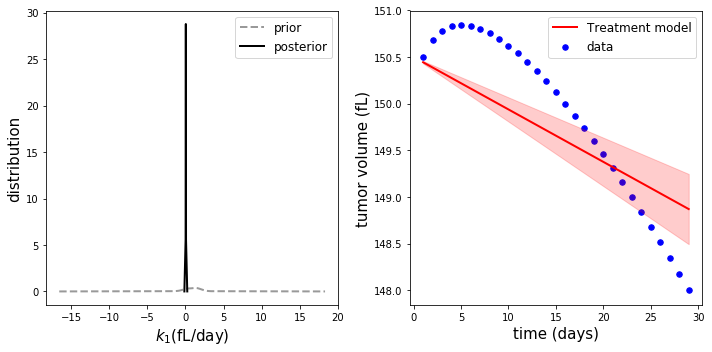

In [5]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(m1, "T_k1", samples=ns)

# train the model
print("\nTraining treatment model...")
_, trace = tu.sample_posterior(m1, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["T_k1"]
tumor_volume_post_samples = np.array([initial_tumor_volume - k1_post_samples[i]*time_data
                                      for i in range(ns)])

# convert all samples to histograms
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlabel(r"$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlabel("time (days)", fontsize=15)
ax2.set_ylabel("tumor volume (fL)", fontsize=15)
ax2.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax2.plot(time_data, tumor_volume_post, "r-", lw=2, label="Treatment model")
ax2.fill_between(time_data,
                 tumor_volume_post - tumor_volume_post_err, 
                 tumor_volume_post + tumor_volume_post_err,
                 color="r", alpha=0.2)

ax1.legend(prop={"size": 12})
ax2.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

And, it doesn't really do a good job. Because the model was given data to train, it does end up adjusting the posterior probability of $k_1$ and narrowing the spread (compared to the prior Normal distribution), but this estimate predicts a sharply linear volume reduction and does not explain why the tumor was still growing till day 6 or so.

This is where your skeptical colleague enters the scene, who has been (unbeknown to you) working on the same problem for sometime. Also, they are a little like this guy:
<div><img src=./tutorial_figs/house.jpg width=400></div>
<br></br>
They are harshly critical of your simple approach and suggest that the most obvious thing you have missed is that the tumor has an internal growth mechanism and is growing all the time throughout the treatment.

### B. The Growth Model <a id="growth_model"></a>

For the sake of this tutorial, assume that your co-worker is really arrogant (the picture above may help) and insists that the internal growth dynamics of the tumor actually overwhelm your therapy and these dynamics are complex enough to explain both the initial increase and subsequent reduction in volume. They even provide a power-law model for the growth $$V(t)=V_0 + k_2t^n$$ where $k_2$ (fL/day) is the steady growth rate and the exponent $n$ is dimensionless.

Basically, your colleague wants to investigate the tumor dynamics with a family of nonlinear models given by the above equation and choose values of both $k_2$ and $n$ that best explains the data. 

At this point, you are (a) frustrated by your own therapy model failing, (b) somewhat browbeat by your coworker and (c) starting to see how their model may be correct since the data is obviously non-linear and they are proposing a non-linear model. So, you give it a shot and build a PGM for the growth model, giving it the same tumor volume profile as evidence. But, being the astute scientist that you are, you leave a little leeway for your own prior belief that the phenomena still might be linear by assuming that $n$ is distributed according to a Normal distribution with mean 0 (and std. dev 0.1). Another prior you impose is that $k_2$ is distributed Normally with a mean of 1.5 fL/day and std. dev 0.1 fL/day. <em>Note: there is another bit of prior assumption that goes into constructing this model, i.e. the treatment has no action.</em>. This is obviously contrived for the purpose of presentation in this tutorial.

The PGM for this model (name it "G") looks like:

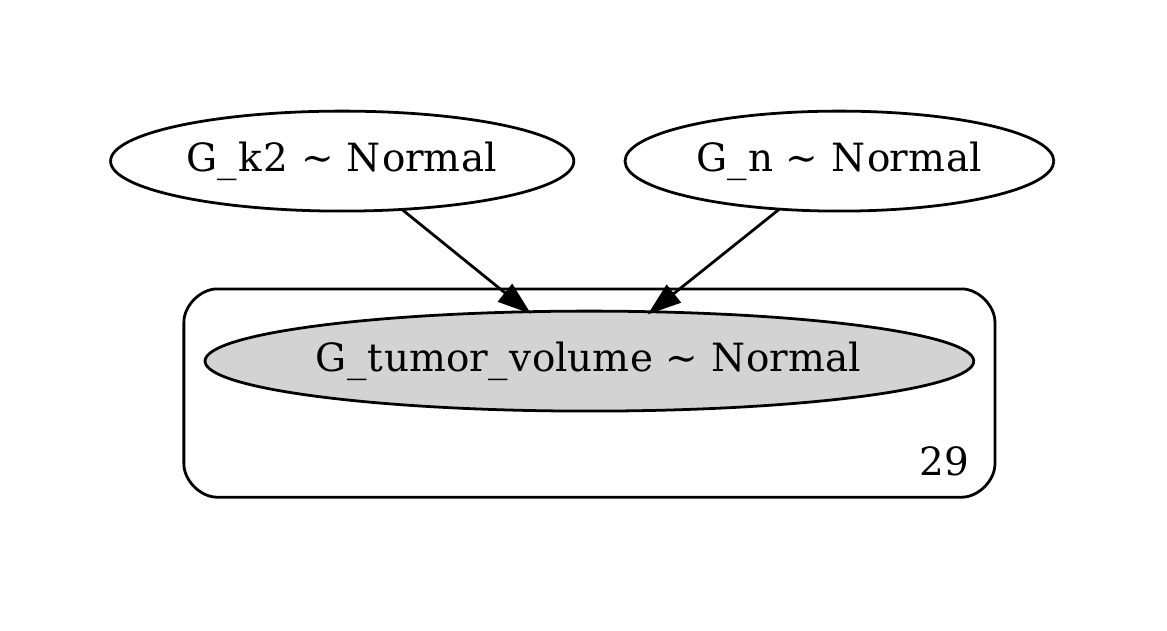

In [6]:
@jit
def GrowthModel(name="G", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    k2 = pm.Normal("k2", mu=1.5, sigma=0.1)
    n = pm.Normal("n", mu=0.0, sigma=0.1)
    V = pm.Normal("tumor_volume", mu=V0+k2*t**n, sigma=0.1, shape=len(t))

m2 = GrowthModel(name="G",
                 inputs={"t":time_data, "V0": initial_tumor_volume},
                 evidence={"G_tumor_volume": tumor_volume_data},
                 start={})
tu.visualize_model(m2, h=600, w=600)

What does this PGM represent? Like before,
1. The nodes ```G_k2``` and ```G_n``` are the increase rate $k_2$ and the exponent $n$ according to your co-worker's proposed growth model/ The node ```G_tumor_volume``` is the volume of the tumor over time $V(t)$. The arrows represent that the tumor volume over time depends on the values of $k_2$ and $n$. Thus, this model has two free parameters $k_2$ and $n$ for which, we would like to choose values that best explain the daily measurement data.


2. The notations ```G_k2 ~ Normal``` and ```G_n ~ Normal``` means that the variables $k_2$ and $n$ are distributed according to Normal distributions (remember, that our prior knowledge says that $k_2 \sim \mathcal{N}(1.5, 0.1)$ and $n \sim \mathcal{N}(0, 0.1)$.

Same routine again, train the growth model given the daily measurement data and check if it makes sense.


Training growth model...


Average Loss = 1,891.6: 100%|██████████| 50000/50000 [00:23<00:00, 2099.47it/s]  
Finished [100%]: Average Loss = 1,891.6


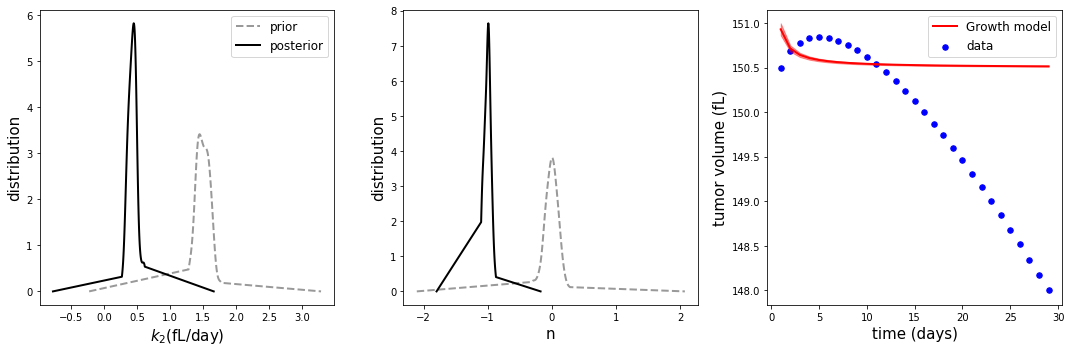

In [7]:
# collect prior samples
k2_pri_samples = tu.get_prior_samples(m2, "G_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(m2, "G_n", samples=ns)

# train the model
print("\nTraining growth model...")
_, trace = tu.sample_posterior(m2, tune=50000, samples=ns)

# collect posterior samples
n_post_samples = trace["G_n"]
k2_post_samples = trace["G_k2"]
tumor_volume_post_samples = np.array([initial_tumor_volume + k2_post_samples[i]*time_data**n_post_samples[i]
                                      for i in range(ns)])

# convert all samples to histograms
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# plot
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(1,3,1)
ax1.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k2_post[0], k2_post[1], "k-", lw=2, label="posterior")

ax2 = fig.add_subplot(1,3,2)
ax2.set_xlabel("n", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(n_post[0], n_post[1], "k-", lw=2)

ax3 = fig.add_subplot(1,3,3)
ax3.set_xlabel("time (days)", fontsize=15)
ax3.set_ylabel("tumor volume (fL)", fontsize=15)
ax3.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax3.plot(time_data, tumor_volume_post, "r-", lw=2, label="Growth model")
ax3.fill_between(time_data, 
                 tumor_volume_post - tumor_volume_post_err,
                 tumor_volume_post + tumor_volume_post_err, 
                 color="r", alpha=0.4)

ax1.legend(prop={"size": 12})
ax3.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

Oops! The treatment model was at least predicting a steady reduction, this model just says that growth stops on its own after day 3 or so. You can see why this happened. The Bayesian estimate of $n$ (in the middle plot) becomes ~ -1.0 such that the growth dynamics becomes slower and slower. So, your colleague wasn't right either (get back at him!). In a real world scenario, if you fit either of these models to your data and then sent the parameters to a wet-lab that wanted to use your treatment (treatment Model) or exploit the tumor's internal growth process (growth Model) to do animal testing, you'd have the blood (sic) of a lot of rats on your head by now.

At this point, you thank yourself that you came to this retreat and attended this tutorial and move on to how you can use these two existing models to come up with a better model.

### C. The "Meta" Model <a id="meta_model"></a>

Instead of throwing away both models and breaking our heads on how to come up with yet another one, lets see if we can combine these to form a model that is informed by the beliefs of both you and your co-worker.

Construct the PGM for the meta-model (name it "MM"):

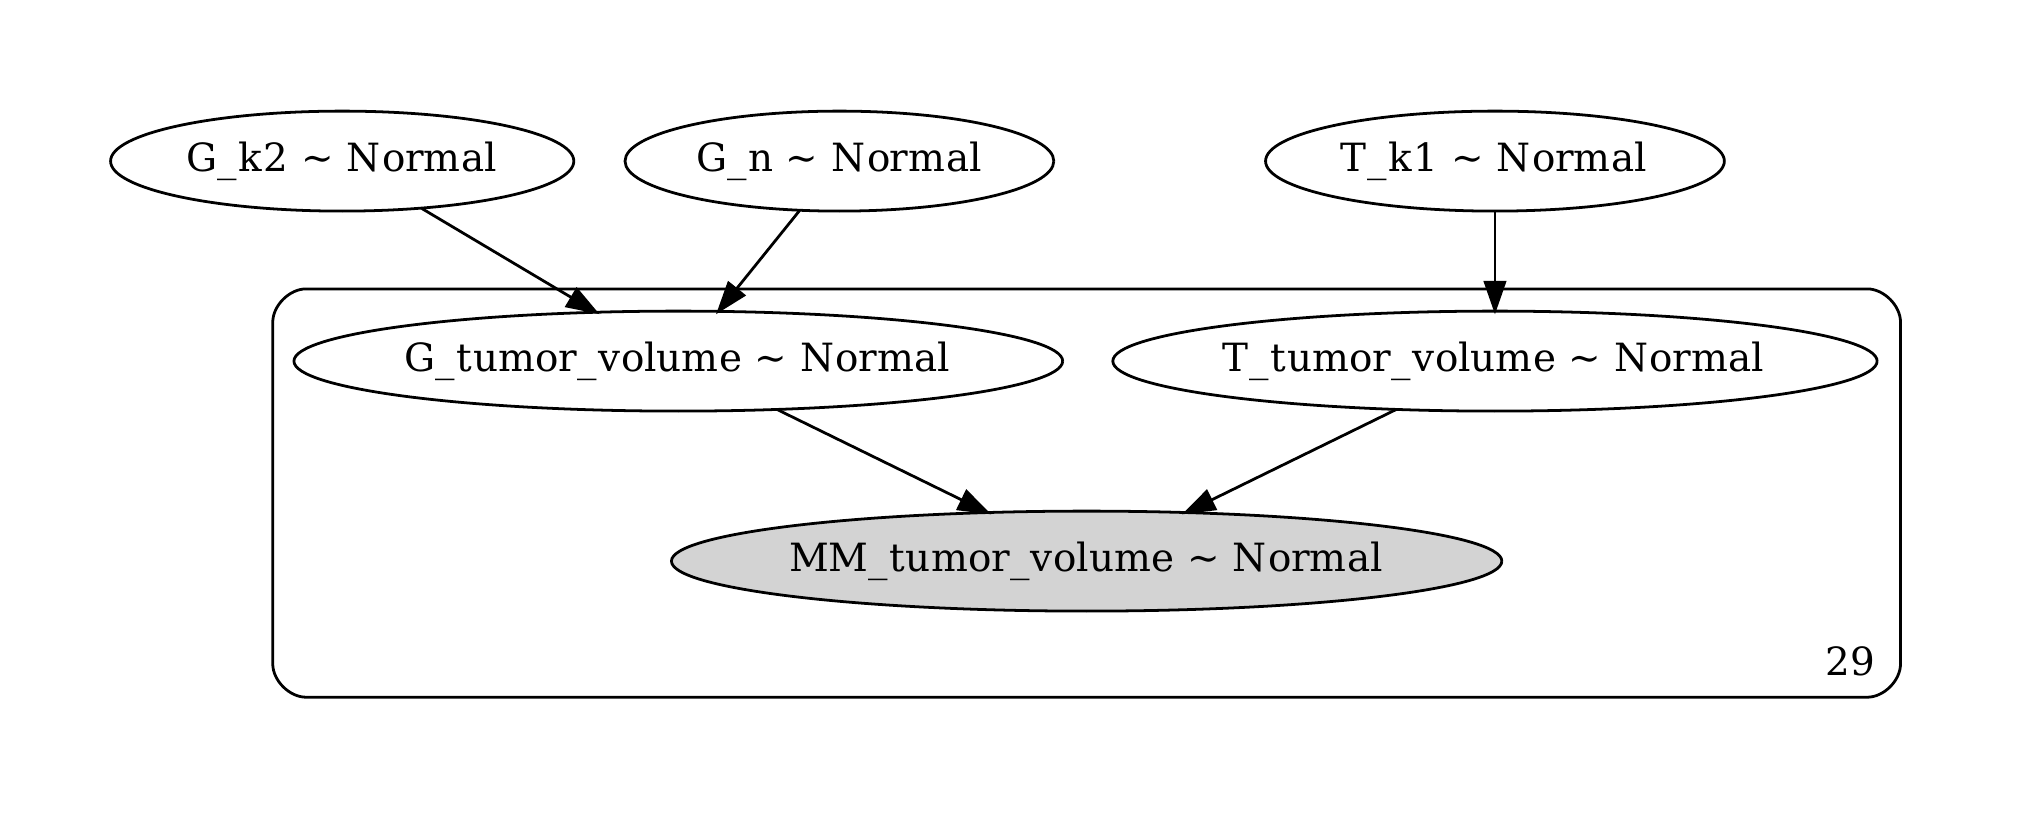

In [8]:
@jit
def MetaModel(name="MM", inputs={}, evidence={}, start={}):
    t = inputs["t"]
    V0 = inputs["V0"]
    
    # call the MBF for the treatment model
    T = TreatmentModel(name="T", inputs=inputs, evidence=evidence, start=start)
    
    # call the MBF for the growth model 
    G = GrowthModel(name="G", inputs=inputs, evidence=evidence, start=start)
    
    # combine (average) the tumor volume predictions from both models
    tumor_volume = pm.Normal("tumor_volume", mu=(T.tumor_volume + G.tumor_volume)/2., sigma=0.1, shape=len(t))
    
m3 = MetaModel(name="MM",
               inputs={"t":time_data, "V0": initial_tumor_volume},
               evidence={"MM_tumor_volume": tumor_volume_data},
               start={})
tu.visualize_model(m3, h=800, w=800)

So, what did we do here? The treatment and growth models with their variables($k_1$ and, ($k_2, n$), respectively) and edges (as defined before in their respective PGMs) still exist, but the tumor volume nodes from each of them (```T_tumor_volume``` and ```G_tumor_volume```) have now been <strong>combined</strong> into a single meta-model node ```MM_tumor_volume```. This combination could be any mathematical function in principle, here we go with the simplest possible expression, an arithmetic average:

$$V_\mathrm{metamodel}(t) = \frac{V_\mathrm{treatment \; model}(t) + V_\mathrm{growth\; model}(t)}{2}$$


The new edges that connect the nodes from either input model ```T_tumor_volume``` and ```G_tumor_volume``` to the meta-model node ```MM_v``` are called <strong>active trails</strong>. Active trails theoretically guarantee flow of information between the two models, e.g. now information can now flow from the ```G_n``` and ```G_k2``` nodes to the ```T_k1``` node and vice versa. All edges can't be active trails and there exist certain well established rules of designing active trails. We shall not pursue further details here, but please reach out if you have questions!

Lets train this model with the same daily tumor volume data as before and see if its any good:


Training meta-model...


Average Loss = 35.226: 100%|██████████| 50000/50000 [00:24<00:00, 2025.35it/s]   
Finished [100%]: Average Loss = 35.212



Avg. uncertainty (std. dev / mean) of tumor volume prediction = 0.08 %


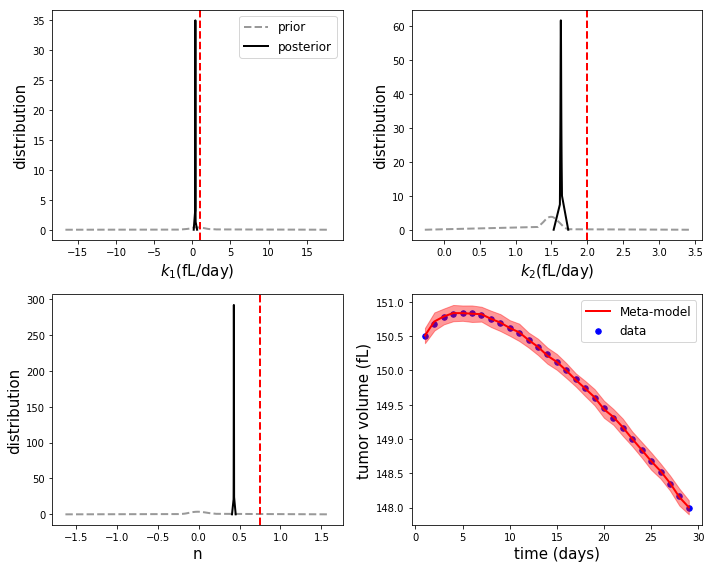

In [9]:
# collect prior samples
k1_pri_samples = tu.get_prior_samples(m3, "T_k1", samples=ns)
k2_pri_samples = tu.get_prior_samples(m3, "G_k2", samples=ns)
n_pri_samples = tu.get_prior_samples(m3, "G_n", samples=ns)

# train the model
print("\nTraining meta-model...")
_, trace = tu.sample_posterior(m3, tune=50000, samples=ns)

# collect posterior samples
k1_post_samples = trace["T_k1"]
k2_post_samples = trace["G_k2"]
n_post_samples = trace["G_n"]
tumor_volume_post_samples = 0.5*(trace["G_tumor_volume"] + trace["T_tumor_volume"])

# convert all samples to distributions 
k1_pri = tu.get_distribution(k1_pri_samples, vartype="static", smooth=True)
k2_pri = tu.get_distribution(k2_pri_samples, vartype="static", smooth=True)
n_pri = tu.get_distribution(n_pri_samples, vartype="static", smooth=True)
k1_post = tu.get_distribution(k1_post_samples, vartype="static", smooth=True)
k2_post = tu.get_distribution(k2_post_samples, vartype="static", smooth=True)
n_post = tu.get_distribution(n_post_samples, vartype="static", smooth=True)
tumor_volume_post, tumor_volume_post_err = tu.get_distribution(tumor_volume_post_samples, vartype="dynamic")

# display the average uncertainty of tumor volume prediction
stderr = 100. * np.mean(tumor_volume_post_err/tumor_volume_post)
print("\nAvg. uncertainty (std. dev / mean) of tumor volume prediction = %2.2f %%" % stderr)

# plot
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel("$k_1 \mathrm{ (fL/day)}$", fontsize=15)
ax1.set_ylabel("distribution", fontsize=15)
ax1.plot(k1_pri[0], k1_pri[1], "k-", lw=2, ls="--", alpha=0.4, label="prior")
ax1.plot(k1_post[0], k1_post[1], "k-", lw=2, label="posterior")
ax1.axvline(k1_target, color="r", ls="--", lw=2)
ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel("$k_2 \mathrm{ (fL/day)}$", fontsize=15)
ax2.set_ylabel("distribution", fontsize=15)
ax2.plot(k2_pri[0], k2_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax2.plot(k2_post[0], k2_post[1], "k-", lw=2)
ax2.axvline(k2_target, color="r", ls="--", lw=2)

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel("n", fontsize=15)
ax3.set_ylabel("distribution", fontsize=15)
ax3.plot(n_pri[0], n_pri[1], "k-", lw=2, ls="--", alpha=0.4)
ax3.plot(n_post[0], n_post[1], "k-", lw=2)
ax3.axvline(n_target, color="r", ls="--", lw=2)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel("time (days)", fontsize=15)
ax4.set_ylabel("tumor volume (fL)", fontsize=15)
ax4.scatter(time_data, tumor_volume_data, s=30, c="blue", label="data")
ax4.plot(time_data, tumor_volume_post, "r-", lw=2, label="Meta-model")
ax4.fill_between(time_data,
                 tumor_volume_post - tumor_volume_post_err,
                 tumor_volume_post + tumor_volume_post_err,
                 color="r", alpha=0.4)

ax1.legend(prop={"size": 12})
ax4.legend(prop={"size": 12})
fig.tight_layout()
plt.show();

Voila! We finally have estimates of $k_1$, $k_2$ and $n$ that can satisfactorily explain the initial growth and subsequent decay of the tumor volume data. The target values of $k_1$, $k_2$ and $n$ that were used to generate the daily tumor volume measurement data (scattered blue dots) are shown in red dotted lines, and although we didn't recapture their exact values, the daily volume estimates we got are sufficient to explain the data with less than 1% uncertainty.

Notice that the estimate of $k_1$ is not too different from its prior estimate while those for $k_2$ and $n$ are. That means the size reduction due to treatment actually dominates the over-all volume profile and growth dynamics only account for the initial growth period. So while neither you or your co-worker were totally accurate, pooling both your knowledge through a rigorous probabilistic framework, helped bring out the best result. In case you didn' notice already, meta-modeling is useful for combining different areas of expertise and divide and conquer in terms of available human and skill level resources!

### D. Summary <a id="summary_2"></a>

In this section, you learned that:

1. Probabilistic graphical models help us visualize and perform posterior estimation for probability distributions over several variables.


2. Probabilistic programming languages like PyMC3 offer a very user-friendly implementation of Bayesian inference problems in such graphical models.


3. Estimating posterior probabilistic distributionsgiven data (evidence) may help reduce uncertainty in the prior estimates of model parameters. 


4. Probabilistic graph representations of different input models can be combined cleverly (through active trails) to ensure information flow between nodes in the different graphs. 


5. Such information flow increases the explanatory power of the combined model.


6. The framework is modular, i.e. models may be partially or completely agonistic of each other. E.g., in this example the treatment model knew nothing about the cell's internal dynamics and the growth model had no idea that an external drug had been administered. Meta-modeling provides the statistical "glue" that enable partially informed models to still talk to each other.

## 3. Building a simple meta-model for beta-cell biology <a id="metamodeling_mm_spt"></a>

<font color="red">This section is considerably advanced in terms of model complexity, and explanations for symbols in the individual PGMs are either absent or mentioned where absolutely necessary. Make sure you understand sections [1](#intro) and [2](#metamodeling_101) before starting this part.</font>

Now that you know how to build meta-models, let us take a less contrived example from beta cell biology. In this section you'll no longer have to define your own MBFs (phew!) and can just import (look at the code) pre-built models. In this tutorial, we'll consider only two models: the <strong>meal model</strong> and the <strong>spt model</strong> (named "meal" and "spt" respectively). Fair warning though, the model PGMs won't look pretty like before, because of the large number of nodes.

The details of the models are left out for now. The PGMs are shown only to demonstrate the complex dependencies within each model. The descriptions below will hopefully provide some context, but for more details, feel free to ask questions.


Meal Model


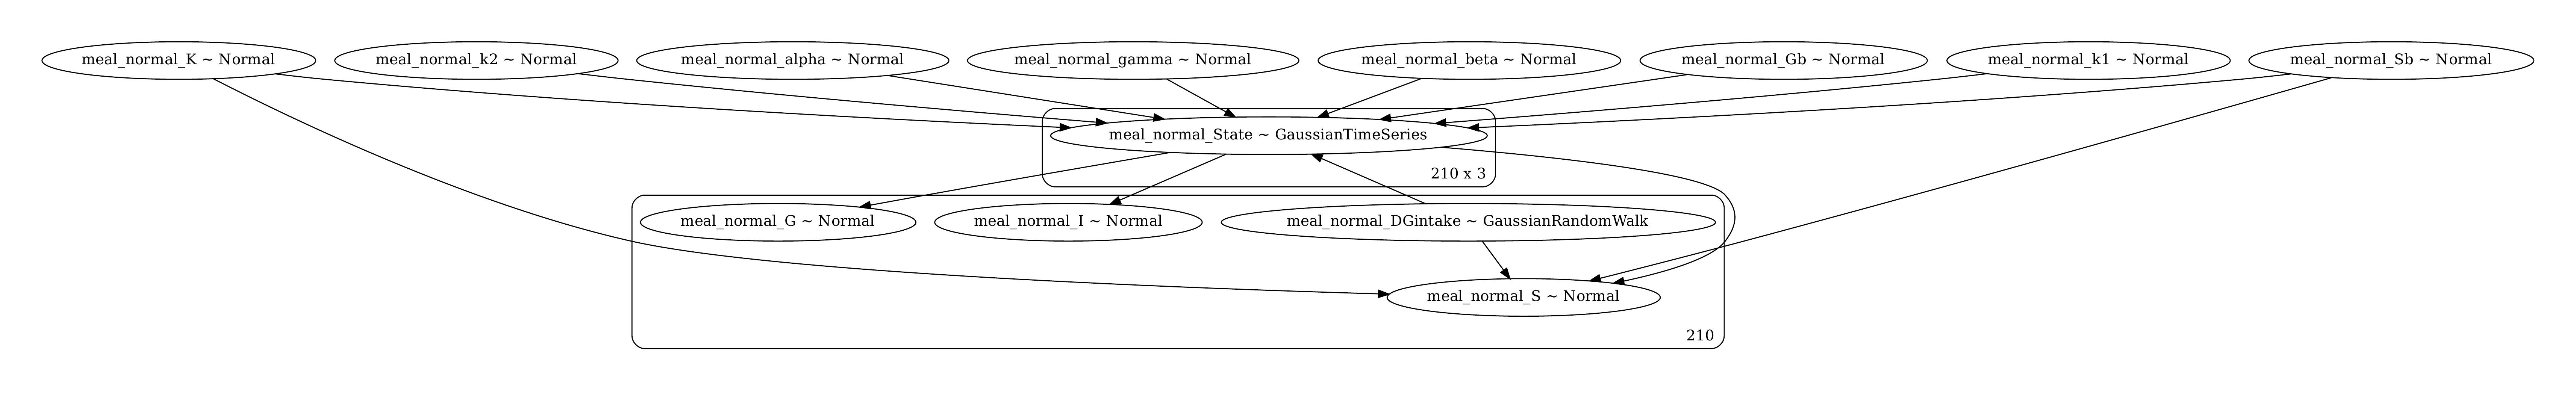


SPT Model


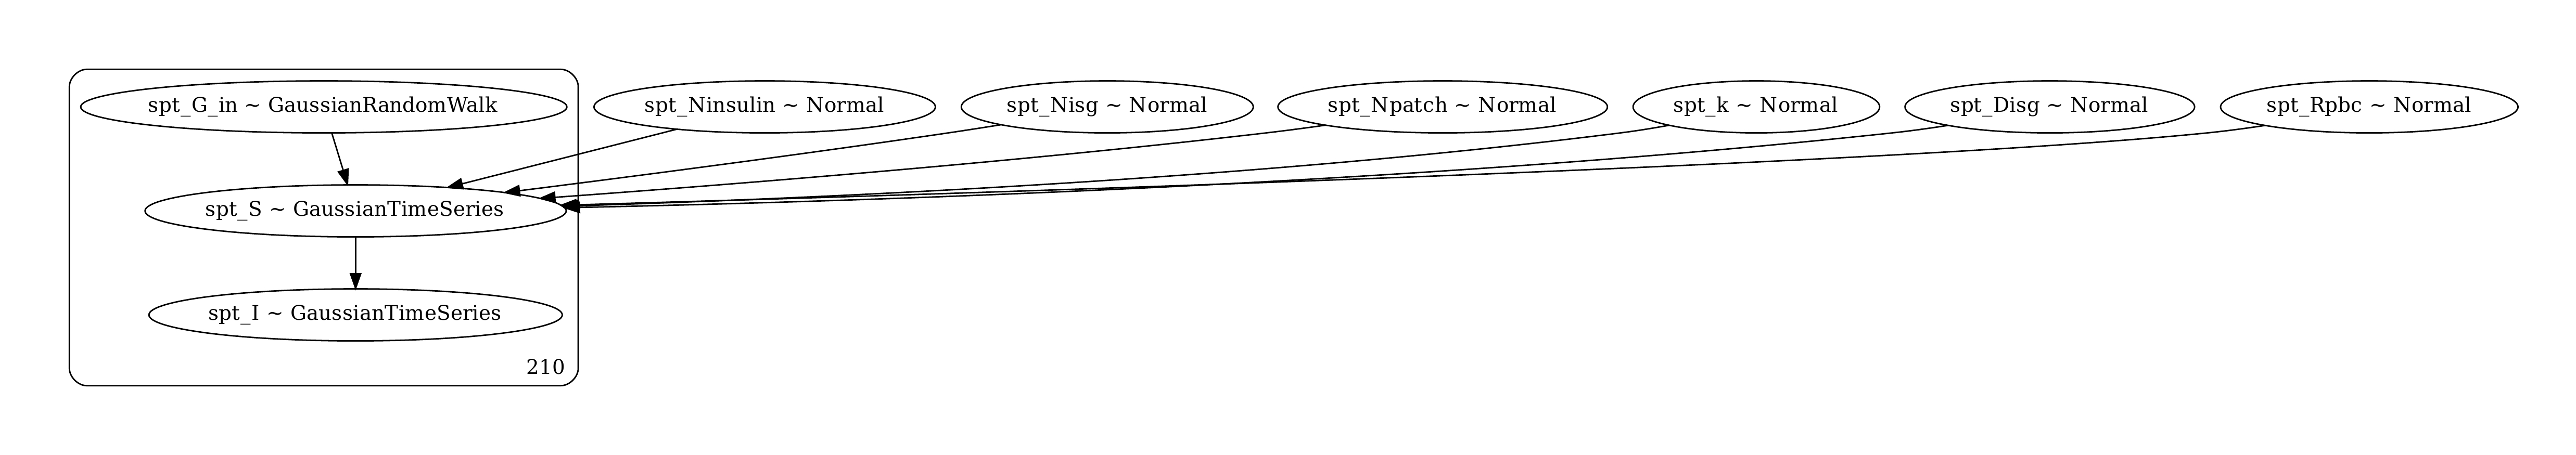

In [10]:
from mm.models import MealModel, SPTModel

meal_1 = MealModel(name="meal_normal", inputs={}, evidence={}, start={}, t=210, hpfn="./tutorial_datasets/default_params.json")
spt_1 = SPTModel(name="spt", inputs={}, evidence={}, start={}, t=210, hpfn="./tutorial_datasets/default_params.json")

print("\nMeal Model")
tu.visualize_model(meal_1, h=1000, w=800)

print("\nSPT Model")
tu.visualize_model(spt_1, h=1000, w=800)

### A. Meal Model <a id="meal_model"></a>
The meal-model is basically a well-known pharamcokinetic model for glucose induced postprandial insulin secretion composed of ordinary differential equations (ODE)s. You can find further details in [this paper](https://ieeexplore.ieee.org/document/4303268). We modified parts of the model so that you can think about it as a simulator that takes as input a concentration profile of ingested glucose (Gintake) and its derivative (DGintake) and produces the reponse concentrations of plasma glucose (G), plasma insulin (I) and insulin secretion rate (S), spatially averaged over the whole pancreas, on the timescale of mins. Two versions of the different model parameters are available in the literature: for "normal" (i.e.e healthy) and "t2d" (type-2 diabetic) patients. 

### B. Spatio Temporal (SPT) Model <a id="spt_model"></a>
SPT stands for (SP)atio-(T)emporal and represents a toy demonstration of a (Brownian dynamics) particle simulator model of the intracellular insulin secretion. <em>It is re-iterated that this simulator is not biologically accurate, but contains sufficient complexity to study the glucose induced insulin vesicle secretion dynamics.</em>

1. The full version of the simulator itself is a much-much simplified representation of the secretion process, where insulin granules are treated as patchy particles that respond to collisions from diffusing glucose molecules, as well as harmonic forces from the cell-wall which represent coarse-grained actin filament interactions.Due to both active (harmonic actin, glucose colliding) and passive (self-diffusing) transport mechanisms, insulin granules are transported to the cell-wall where they can get secreted. Something like this:


![SPTModel](./tutorial_figs/spt.gif "spt model")


2. The SPT model in this example is a <strong>further simplification in terms of lengths and time-scales in that we assume that the intra-cellular glucose and insulin concentrations as well as insulin secretion rates are at comparable length and time-scales to the meal model</strong>. Relaxing this assumption will need more robust coupling strategies that mitigate the length and time-scaling issues between the characteristic time-scales of a PK/PD model (minutes) and a mesoscopic particle simulation model (pico-seconds at best)


3. The length-scaling is acheived internally by treating each beta-cell as an independent secretory unit so that the total secretion from the pancreas is simply # of cells times the individual secretion.

### C. The Meta Model (with a healthy dose of meta-modeling philosophy!) <a id="meta_model_meal_spt></a>
As explained before, the crucial protocol that allows one to couple two or more models represented as graphical models is the fact that putting an edge between two nodes in a graphical model may create <strong>active trails</strong> which initiate information flow between them. As shown in the figure below, these (red) edges can be between nodes belonging to different input models.

<div><img src="./tutorial_figs/mm_meal_spt.png" width="800"></div>

Thus, here the glucose concentration profile for the intra-cellular spt model is implemented as an "input" (see section [2.A.](#treatment_model)) taken from the plasma glucose concentration profile for the meal model. Further the plasma insulin concentrations from both models are combined (arithmetically averaged, similar to the metamodel in section [2.C](#meta_model)) to produce a hybrid insulin profile (I_meta in the figure above) which carries information from both models. Why would anyone want to do such a hybrid combination, you ask? Remember, this is a toy example focused on demonstrating the information flow processes!

This also points to a very important note about the meta-modeling philsophy. It has come to our attention that a lot of you have thought about meta-modeling as gathering different pieces of information (experimental data, e.g.) and putting everything together into a [CellPack](http://www.cellpack.org/) model. While that is certainly a possible direction, our approach is agonstic to model representation. If one adopted the CellPack approach, one would be finally working in terms of particle coordinates as the over-arching representation. <strong>With meta-modeling however, we can let the models have their own representation with very different degrees of freedom. The meal model e.g. consists of only chemical concentrations while the spt model (in principle, considering the full Brownian dynamics simulator) need contain only particle coordinates. The statistical framework offered by PGMs is the representational unification magic that makes meta-modeling (in its current form) possible!</strong>

Moving on, we will create a meta-model (named "meta") from the (pre-built) meal and spt models and use the two couplers mentioned above.

Quick note (need to look at the code using the toggle button; you can ignore this if you want): we will pass an argument called hpfn to all model-builder functions. This stands for (h)yperprior (f)ile(n)ame. It is a json file containing all the <em>hyperpriors</em> (i.e. parameters used to define the prior probability distributions such as sigmas for Gaussian distributions, starting values for timeseries variables, etc). For this tutorial, a set of best-guess estimates of these quantities (meticulously curated by Liping Sun, Sali lab) have been kept in a file called ```tutorial_datasets/default_params.json```.

In [11]:
HP_FN = "./tutorial_datasets/default_params.json"

@jit
def MetaModel(name="meta", t=100,
              inputs={}, evidence={}, start={}, 
              hpfn=HP_FN, mealmodel_type="normal"):
    
    # call the meal model MBF
    mealmodel_name = "meal_%s" % mealmodel_type # normal or t2d
    meal = MealModel(name=mealmodel_name, t=t, inputs=inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # construct the first coupler (a modified inputs for the spt model)
    # intracellular glucose ~ 50% of extracellular glucose # assumption
    spt_inputs = {"G_in": 0.5*meal.G}
    
    # call the spt model MBF and pass in the first coupler
    spt = SPTModel(name="spt", t=t, inputs=spt_inputs, evidence=evidence, start=start, hpfn=hpfn)
    
    # combine (average) the plasma insulin (I) from meal and spt models
    I = pm.Normal("I", mu=(meal.I + spt.I)/2., sigma=0.01)

Once we have defined the MBF, we need to supply the inputs, evidence and start for this system, as elaborated in section [2.A](#treatment_model). Data for this example is stored in files in the ```tutorial_datasets``` directory.

<strong>```inputs```</strong>
<br></br>
The input for this meta-model is the derivative of ingested glucose concentration ($\mathrm{DGintake} = \frac{d}{dt} \; \mathrm{Gintake}$) as a function of time (discretized for 420 mins with an interval $dt$=2 mins). Lets see what this profile looks like and load it into the ```inputs``` dict.

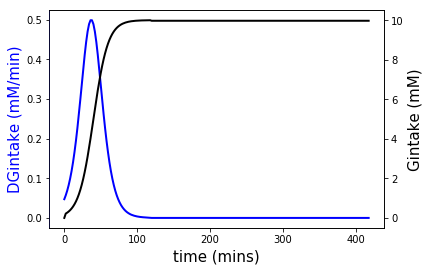

In [12]:
# timestep
dt = 2.0

# extract input data
input_data = np.loadtxt("./tutorial_datasets/Gintake.dat")
t_data = dt * input_data[:,0]
Gintake_data = input_data[:,2]
DGintake_data = input_data[:,1]

# load into dict
inputs = {"DGintake": DGintake_data}

# plot
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(1,1,1)
ax1.set_xlabel("time (mins)", fontsize=15)
ax1.set_ylabel("DGintake (mM/min)", fontsize=15)
ax1.spines['left'].set_color('blue') ; ax1.yaxis.label.set_color('blue')
ax1.plot(t_data, DGintake_data, "b-", lw=2, label="DGintake")

ax2 = ax1.twinx()
ax2.set_ylabel("Gintake (mM)", fontsize=15)
ax2.plot(t_data, Gintake_data, "k-", lw=2);

<strong>```evidence```</strong>
<br></br>
The evidence used in this demonstration is a profile of plasma insulin concentrations for normal (healthy) and t2d (type-2 diabetic) cases, taken from literature. These are not exactly experimental data, rather outputs of more complex meal simulation models. Let's look at these profiles and load them into the ```evidence``` dict.

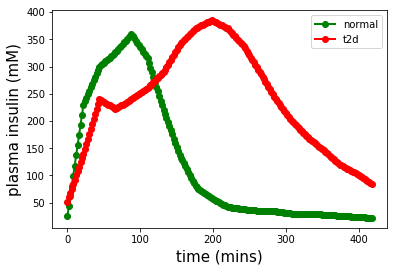

In [13]:
# extract data
normal_data = np.loadtxt("./tutorial_datasets/glucose_insulin_normal.dat")
t2d_data = np.loadtxt("./tutorial_datasets/glucose_insulin_t2d.dat")
I_normal_data = normal_data[:,2]
I_t2d_data = t2d_data[:,2]

# load into evidence dict (use full names of variable, i.e. meta-model name + "_" + variable name)
evidence_normal = {"meta_I": I_normal_data}
evidence_t2d =    {"meta_I": I_t2d_data}

# plot
plt.plot(t_data, I_normal_data, "go-", lw=2, label="normal")
plt.plot(t_data, I_t2d_data, "ro-", lw=2, label="t2d")
plt.xlabel("time (mins)", fontsize=15)
plt.ylabel("plasma insulin (mM)", fontsize=15)
plt.legend()
plt.show();

<strong>```start```</strong>
<br></br>
This system has time-varying quantities that depend on their previous time points (plasma glucose, plasma insulin, insulin secretion), so a ```start``` containing values of such quantities at $t=0$ must be provided. These values are already stored in the hyper-parameter file (```tutorial_datasets/default.json```, loaded in the ```HP_FN``` variable). Here, we will load them into variables using a helper function.

In [14]:
start_normal = {"meal_normal_State":  set_start(rvname="State", modelname="meal_normal", hpfn=HP_FN),
                "spt_S"            :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
                "spt_I"            :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

start_t2d = {"meal_t2d_State"      :  set_start(rvname="State", modelname="meal_t2d", hpfn=HP_FN),
             "spt_S"               :  set_start(rvname="S", modelname="spt", hpfn=HP_FN),
             "spt_I"               :  set_start(rvname="I", modelname="spt", hpfn=HP_FN)}

### D. Bayesian parameter inference from the meta-model <a id="meta_model_meal_spt_inference"></a>
Let's build two PGMs of the meta-model, once with normal parameters for the component meal model and another with t2d parameters.


Building meta-model from meal and spt models for normal data...

Building meta-model from meal and spt models for t2d data...

PGM of the normal case (double click on the PGM to zoom in)


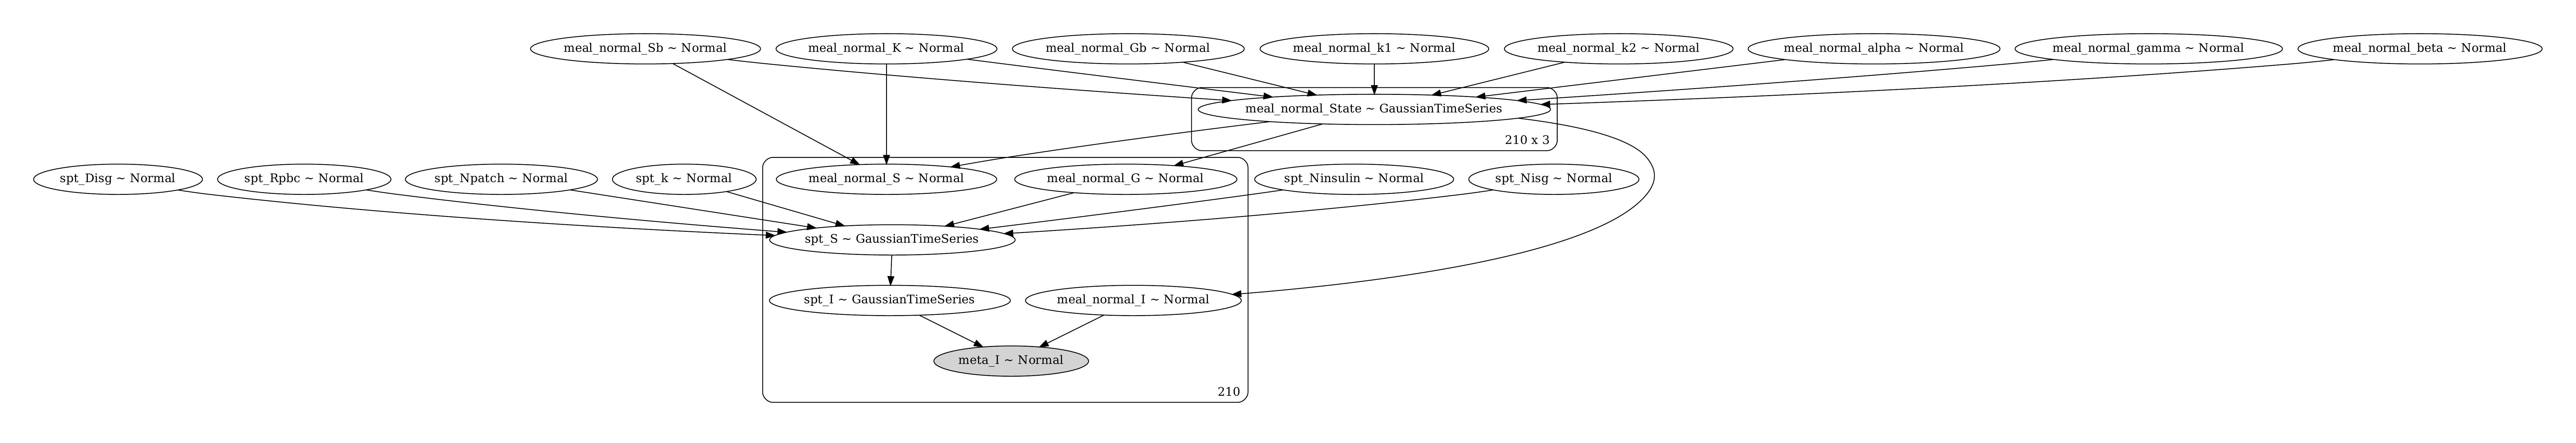

In [15]:
# number of time points
nt = len(DGintake_data)

# build the meta-models
print("\nBuilding meta-model from meal and spt models for normal data...")
mm_normal = MetaModel(name="meta", inputs=inputs, evidence=evidence_normal, start=start_normal, t=nt,
                       hpfn=HP_FN, mealmodel_type="normal")

print("\nBuilding meta-model from meal and spt models for t2d data...")
mm_t2d = MetaModel(name="meta", inputs=inputs, evidence=evidence_t2d, start=start_t2d, t=nt,
                  hpfn=HP_FN, mealmodel_type="t2d")
                         
# visualize the normal model (the t2d has the same topology, just different parameters)
print("\nPGM of the normal case (double click on the PGM to zoom in)")
tu.visualize_model(mm_normal, h=2500, w=2500)

Note how all nodes belong implicitly to the scope of their own models. Thus nodes derived from the meal model all have the prefix ```meal_normal``` (or t2d) and nodes from the spt model are prefixed with ```spt```. Only the combined plasma insulin node (to which evidence is provided, hence shaded) is in the <em>meta</em> scope and hence prefixed with the name of the meta-model ```meta```. <strong>Also just to avoid confusion, lets recall that notation such as ```meal_normal_S ~ Normal``` means that the variable called ```S``` (insulin secretion rate) from the model called ```meal_normal``` has a Normal i.e. Gaussian conditional probability distribution.</strong>. 

For the rest of this section, we'll focus on three quantities: the actin network force constant $k$ from the spt model, the basal glucose level $G_b$ from the meal model and the insulin secretion rate $S$ from the meal model.

Alrighty, its training time! Train both metamodels (normal and t2d) and collect posterior samples of $k$, $G_b$ and $S$. Training might take a while, so now is the time to go grab coffee :)

In [16]:
# collect prior samples from normal case
k_normal_pri_samples = tu.get_prior_samples(mm_normal, "spt_k", samples=ns)
Gb_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_Gb", samples=ns)
S_normal_pri_samples = tu.get_prior_samples(mm_normal, "meal_normal_S", samples=ns)

# collect prior samples from t2d case
k_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "spt_k", samples=ns)
Gb_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_Gb", samples=ns)
S_t2d_pri_samples = tu.get_prior_samples(mm_t2d, "meal_t2d_S", samples=ns)

# train normal case
print("\nTraining the meta-model on the normal data...")
_, trace_normal = tu.sample_posterior(mm_normal, tune=50000, samples=ns)
# co# collect prior samplesllect samples from posterior
k_normal_post_samples = trace_normal["spt_k"]
Gb_normal_post_samples = trace_normal["meal_normal_Gb"]
S_normal_post_samples = trace_normal["meal_normal_S"]

# train t2d case
print("\nTraining the meta-model on the t2d data...")
_, trace_t2d = tu.sample_posterior(mm_t2d, tune=50000, samples=ns)
# collect samples from posterior
k_t2d_post_samples = trace_t2d["spt_k"]
Gb_t2d_post_samples = trace_t2d["meal_t2d_Gb"]
S_t2d_post_samples = trace_t2d["meal_t2d_S"]

# convert prior samples to distributions
k_normal_pri = tu.get_distribution(k_normal_pri_samples, vartype="static", smooth=True)
Gb_normal_pri = tu.get_distribution(Gb_normal_pri_samples, vartype="static", smooth=True)
S_normal_pri, S_normal_pri_err = tu.get_distribution(S_normal_pri_samples, vartype="dynamic")
k_t2d_pri = tu.get_distribution(k_t2d_pri_samples, vartype="static", smooth=True)
Gb_t2d_pri = tu.get_distribution(Gb_t2d_pri_samples, vartype="static", smooth=True)
S_t2d_pri, S_t2d_pri_err = tu.get_distribution(S_t2d_pri_samples, vartype="dynamic")

# convert posterior samples to distributions
k_normal_post = tu.get_distribution(k_normal_post_samples, vartype="static", smooth=True)
Gb_normal_post = tu.get_distribution(Gb_normal_post_samples, vartype="static", smooth=True)
S_normal_post, S_normal_post_err = tu.get_distribution(S_normal_post_samples, vartype="dynamic")
k_t2d_post = tu.get_distribution(k_t2d_post_samples, vartype="static", smooth=True)
Gb_t2d_post = tu.get_distribution(Gb_t2d_post_samples, vartype="static", smooth=True)
S_t2d_post, S_t2d_post_err = tu.get_distribution(S_t2d_post_samples, vartype="dynamic")


Training the meta-model on the normal data...


Average Loss = 2.1778e+10: 100%|██████████| 50000/50000 [00:45<00:00, 1101.26it/s]
Finished [100%]: Average Loss = 2.1778e+10



Training the meta-model on the t2d data...


Average Loss = 4.4755e+10: 100%|██████████| 50000/50000 [00:45<00:00, 1096.89it/s]
Finished [100%]: Average Loss = 4.4754e+10


Now, lets first see the estimates of the basal glucose level $G_b$ 

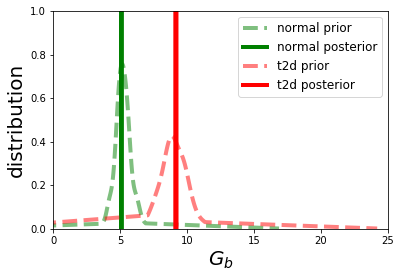

In [17]:
plt.plot(Gb_normal_pri[0], Gb_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(Gb_normal_post[0], Gb_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(Gb_t2d_pri[0], Gb_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(Gb_t2d_post[0], Gb_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,25.0])
plt.ylim([0,1.0])
plt.xlabel(r"$G_b$", fontsize=20)
plt.ylabel("distribution", fontsize=20)
plt.legend(prop={"size":12});

As you can see, the posterior distributions of $G_b$ have much less (yeah those straight lines are actually super-narrow Gaussians!) noise than their priors. Bonus: basal glucose level for t2d data is higher than that for normal which makes sense! <strong>This is an important motivation for probabilistic meta-modeling. Connecting component models and allowing information flow between them allows us to refine our estimates of model parameters. </strong>

Next look at the actin network imposed force constant $k$.

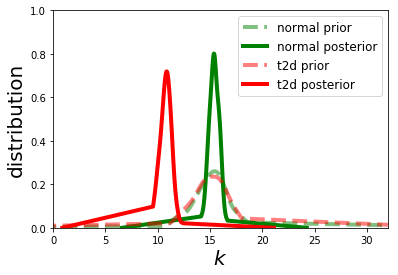

In [18]:
plt.plot(k_normal_pri[0], k_normal_pri[1], "g--", lw=4, alpha=0.5, label="normal prior")
plt.plot(k_normal_post[0], k_normal_post[1], "g-", lw=4, label="normal posterior")

plt.plot(k_t2d_pri[0], k_t2d_pri[1], "r--", lw=4, alpha=0.5, label="t2d prior")
plt.plot(k_t2d_post[0], k_t2d_post[1], "r-", lw=4, label="t2d posterior")

plt.xlim([0,32.0])
plt.ylim([0,1.0])
plt.xlabel(r"$k$", fontsize=20)
plt.ylabel(r"distribution", fontsize=20)
plt.legend(prop={"size":12});

Again, as expected, the posterior estimates of $k$ are much more confident than their prior distributions. More importantly, the priors for both normal and t2d case for $k$ are same while the posterior under t2d shifts to a lower average value. What does that mean?

1. Clearly the spt model <em>prior</em> to meta-modeling had no idea what t2d is (which is why their priors look the same), but proper information flow from the t2d paramters in the t2d meal model updates the posterior $k$ distribution.


2. <strong>This underscores another motivation for probabilistic meta-modeling, namely, a tool for determining parameters (with measurable uncertainty) which are unknown or hard to measure in experiment.</strong>


3. Indeed, if you consider what $k$ really is: in principle, it is a harmonic spring force constant that represents the average effect of the entire actin network inside the beta cell, and arguably very hard to measure or even conceive in experiment (if not impossible). In this short numerical experiment, we assumed that we know $k$ under healthy conditions (to some degree of uncertainty) and used plasma insulin data from the meta-model to estimate its value under diabetic conditions.


4. Bonus biological insight (didn't see that coming, did you?!) Lower $k$ under t2d conditions reflects slower granule trafficking to the cell membrane and thus lower overall secretion from the cell.

Finally, let's confirm point # 4 above. Look at the secretion rates:

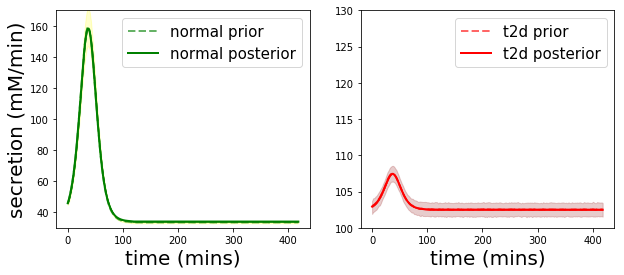

In [19]:
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(t_data, S_normal_pri, "g--", lw=2, alpha=0.6, label="normal prior")
ax1.fill_between(t_data, S_normal_pri-S_normal_pri_err, S_normal_pri+S_normal_pri_err, color="yellow", alpha=0.2)
ax1.plot(t_data, S_normal_post, "g-", lw=2, label="normal posterior")
ax1.fill_between(t_data, S_normal_post-S_normal_post_err, S_normal_post+S_normal_post_err, color="g", alpha=0.7)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(t_data, S_t2d_pri, "r--", lw=2, alpha=0.6, label="t2d prior")
ax2.fill_between(t_data, S_t2d_pri-S_t2d_pri_err, S_t2d_pri+S_t2d_pri_err, color="darkred", alpha=0.2)
ax2.plot(t_data, S_t2d_post, "r-", lw=2, label="t2d posterior")
ax2.fill_between(t_data, S_t2d_post-S_t2d_post_err, S_t2d_post+S_t2d_post_err, color="r", alpha=0.7)

ax1.set_xlabel("time (mins)", fontsize=20)
ax1.set_ylabel("secretion (mM/min)", fontsize=20)
ax1.set_ylim([30, 170])
ax1.legend(prop={"size": 15})

ax2.set_xlabel("time (mins)", fontsize=20)
ax2.set_ylim([100, 130])
ax2.legend(prop={"size":15});

The secretion rate under diabetic conditions indeed is about ~50% lower than under normal conditions. While that increase percentage may not be numerically accurate (remember, these are toy models!), it does serve as yet another (indirect) validation of effective information flow between the two models. As usual, the posterior profiles have much lesser uncertainty than the priors but the average values are not too different. This is expected since the meal model has t2d specific parameters, so that the priors on $S$ are <em>already quite informative to start with</em>, unlike the $k$ in the spt model.

### E. Summary and Outlook <a id="summary_3"></a>

Hopefully you are convinced now that:

1. Meta-modeling can refine the estimates of model parameters.


2. Meta-modeling can estimate parameters of models that are either unknown or hard to measure, given data.


3. Data used to train and estimate parameters can be provided to any node on any component model, doesn't need to be tied to the model to which the unknown parameters belong.


4. These advantages of meta-modeling are propelled by rigorous information flow protocols that are mathematically guaranteed if edges are drawn correctly between the underlying probabilistic graph representations of the different models.

The couplers designed in this short example were chosen in a way that automatically guarantees information flow according to the rules of probability theory and Bayes theorem. While these rules provide some heuristics, they don't provide absolute guidelines to design these couplers automatically. It'd be an important future direction to be able to automate the couplers such that no human decision is required to construct them.

But even before that, it is necessary to (human) design couplers that can work efficiently bridging across length and time scales when more realistic models (unlike the <em>statistical</em> toy models you saw here) that have real differences in length and time-scales are coupled.